In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from astropy.table import Table, vstack, Column
import os
import pdb
import warnings
import sys
import pandas as pd
from pandas import DataFrame as df

working_dir = '/Users/Gianna/Documents/GitHub/SIP2019/'

sys.path

['',
 '/Users/Gianna/Documents/GitHub/SIP2019/Giovanni',
 '/Users/Gianna/anaconda3/lib/python37.zip',
 '/Users/Gianna/anaconda3/lib/python3.7',
 '/Users/Gianna/anaconda3/lib/python3.7/lib-dynload',
 '/Users/Gianna/anaconda3/lib/python3.7/site-packages',
 '/Users/Gianna/anaconda3/lib/python3.7/site-packages/aeosa',
 '/Users/Gianna/anaconda3/lib/python3.7/site-packages/IPython/extensions',
 '/Users/Gianna/.ipython']

In [26]:
objtypes=[]
objfiles=[]

degc,halo,denu,udg,icl = [],[],[],[],[]

path1 = './../spectra/'

bigFile = Table.read('bigfile-Copy1.fits')
allnames=list(bigFile['SPEC1DNAME'])

for filename in os.listdir(path1):
    if ((filename in allnames) | ((filename + '.gz') in allnames)):
        if ('.gz' in filename):
            objtypes = (str((bigFile[bigFile['SPEC1DNAME']==filename])['Type']))
        else:
            objtypes = (str((bigFile[bigFile['SPEC1DNAME'] == filename + '.gz'])['Type']))
        if ('DEGC' in objtypes):
            degc.append(filename)
        elif ('Halo' in objtypes):
            halo.append(filename)
        elif ('DENU' in objtypes):
            denu.append(filename)
        elif ('UDG' in objtypes):
            udg.append(filename)
        elif ('ICL' in objtypes):
            icl.append(filename)
            
#there are no .gz files for denu.... I have no idea if that's screwed up or not

In [3]:
sys.path.append(working_dir + 'lib')

from py_specrebin import rebinspec

correct = np.arange(4000,8750.9,0.9)

i = 0

In [17]:
vobsDEGC, vobsHalo, vobsDENU, vobsUDG, vobsICL = [],[],[],[],[]

def vobs(objfiles):
    vobszero = np.zeros(len(objfiles))
    for i in range(len(objfiles)):
        try:
            vobszero[i]=(float(bigFile[bigFile['SPEC1DNAME'] == objfiles[i]]['VOBS']))
        except:
            vobszero[i]=(float(bigFile[bigFile['SPEC1DNAME'] == objfiles[i] + '.gz']['VOBS']))
    return vobszero

vobsDEGC = vobs(degc)
vobsHalo = vobs(halo)
vobsDENU = vobs(denu)
vobsUDG = vobs(udg)
vobsICL = vobs(icl)

In [18]:
def coaddition(objfiles, velocities):
    allfluxes = []
    alllambdas = []
    allvariances = []
    for i in range(len(objfiles)):
        f = fits.open(path1 + objfiles[i])

        try:
            specB = f['Bxspf-' + 'B'] # Look through 'Bxspf-' for blue and red before looking through 'Horne-'
            specR = f['Bxspf-' + 'R']
        except:
            specB = f['Horne-' + 'B']
            specR = f['Horne-' + 'R']
        
        nuewaveB= specB.data['LAMBDA']
        antiguoB= nuewaveB/(1+((velocities[i]/300000))) #Doppler shift correction (300,000 = speed of light)
        nuewaveR= specR.data['LAMBDA']
        antiguoR= nuewaveR/(1+((velocities[i]/300000)))
        alllambdas.append(np.append(antiguoB,antiguoR)) # Blue lambdas to red
        allfluxes.append(np.append(specB.data['SPEC'],specR.data['SPEC'])) # Blue spectras to red 
        allvariances.append(np.append(specB.data['IVAR'],specR.data['IVAR'])) # Blue variances to red
        f.close()
    return alllambdas, allfluxes, allvariances

In [28]:
tlDEGC, tfDEGC, tvDEGC = coaddition(degc, vobsDEGC)
tlHalo, tfHalo, tvHalo = coaddition(halo,vobsHalo)
tlDENU, tfDENU, tvDENU = coaddition(denu, vobsDENU)
tlUDG, tfUDG, tvUDG = coaddition(udg, vobsUDG)
tlICL, tfICL, tvICL = coaddition(icl, vobsICL)

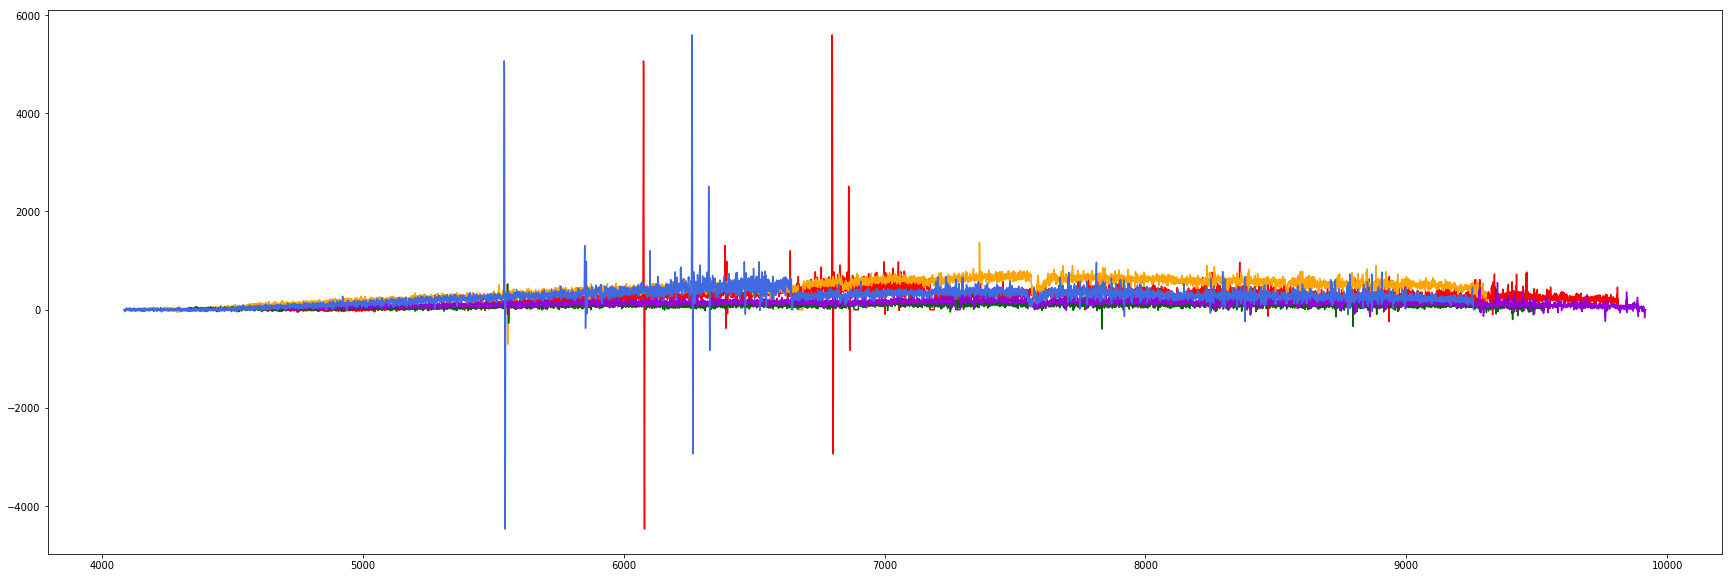

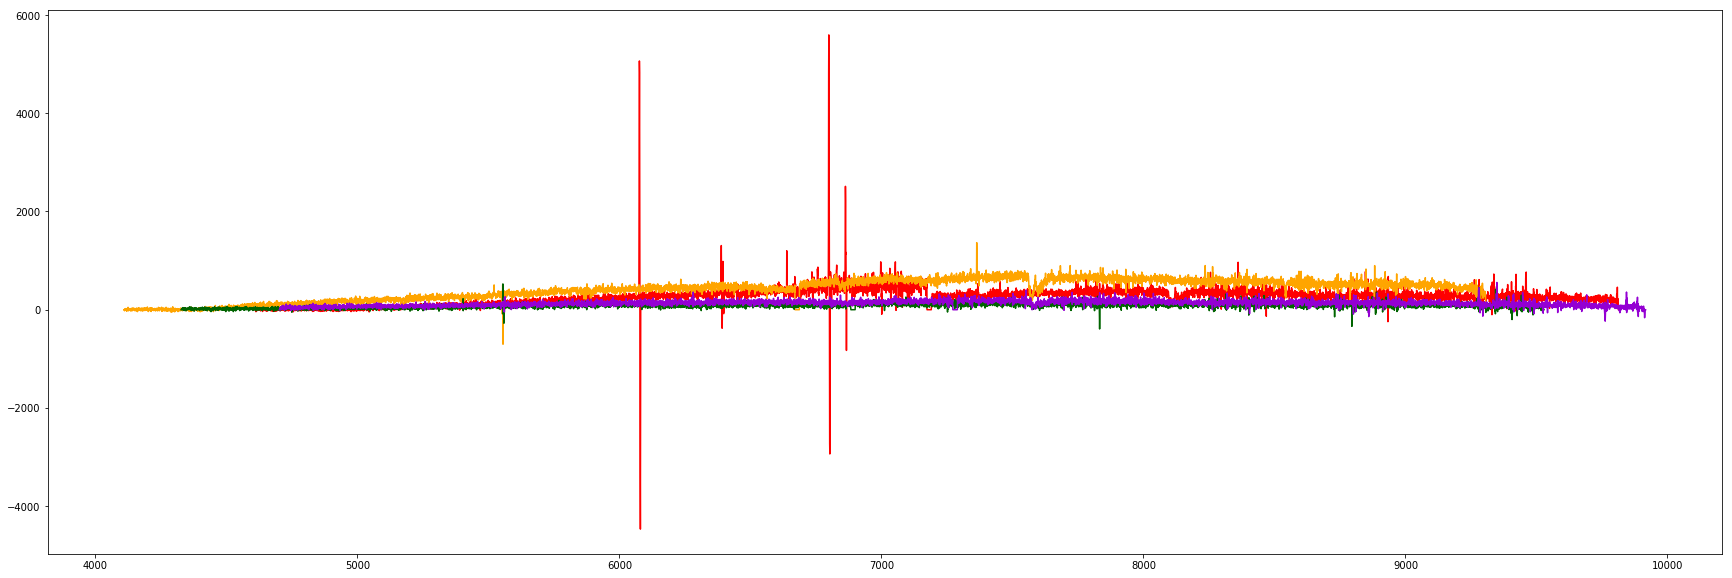

In [7]:
plt.figure(figsize=(30,10))
plt.plot(tlDEGC[0], tfDENU[0], color = 'r')
plt.plot(tlHalo[0], tfHalo[0], color = 'orange')
plt.plot(tlUDG[0], tfUDG[0], color = 'darkgreen')
plt.plot(tlICL[0],tfICL[0], color = 'darkviolet')
plt.plot(tlDENU[0],tfDENU[0], color = 'royalblue')
plt.show()

plt.figure(figsize=(30,10))
plt.plot(tlDEGC[0], tfDENU[0], color = 'r')
plt.plot(tlHalo[0], tfHalo[0], color = 'orange')
plt.plot(tlUDG[0], tfUDG[0], color = 'darkgreen')
plt.plot(tlICL[0],tfICL[0], color = 'darkviolet')
plt.show()

In [8]:
fluxesDEGC = np.zeros((len(tlDEGC), len(correct)))
varsDEGC = np.zeros((len(tlDEGC), len(correct)))

for i in range(len(tlDEGC)):   #rebinning DEGC
    newfluxDEGC, newvarDEGC = np.nan_to_num(rebinspec(tlDEGC[i], tfDEGC[i], correct, ivar = tvDEGC[i]))
    fluxesDEGC[i][:] = newfluxDEGC
    varsDEGC[i][:] = newvarDEGC
    
fluxesUDG = np.zeros((len(tlUDG), len(correct)))
varsUDG = np.zeros((len(tlUDG), len(correct)))

for i in range(len(tlUDG)):  #rebinning star
    newfluxUDG, newvarUDG = np.nan_to_num(rebinspec(tlUDG[i], tfUDG[i], correct, ivar = tvUDG[i]))
    fluxesUDG[i][:] = newfluxUDG
    varsUDG[i][:] = newvarUDG

fluxesH = np.zeros((len(tlHalo), len(correct)))
varsH = np.zeros((len(tlHalo), len(correct)))

for i in range(len(tlHalo)):   #rebinning halo
    newfluxH, newvarH = np.nan_to_num(rebinspec(tlHalo[i], tfHalo[i], correct, ivar = tvHalo[i]))
    fluxesH[i][:] = newfluxH
    varsH[i][:] = newvarH
    
fluxesDENU = np.zeros((len(tlDENU), len(correct)))
varsDENU = np.zeros((len(tlDENU), len(correct)))

for i in range(len(tlDENU)):  #rebinning DENU
    newfluxDENU, newvarDENU = np.nan_to_num(rebinspec(tlDENU[i], tfDENU[i], correct, ivar = tvDENU[i]))
    fluxesDENU[i][:] = newfluxDENU
    varsDENU[i][:] = newvarDENU

fluxesICL = np.zeros((len(tlICL), len(correct)))
varsICL = np.zeros((len(tlICL), len(correct)))

for i in range(len(tlICL)):   #rebinning ICL
    newfluxICL, newvarICL = np.nan_to_num(rebinspec(tlICL[i], tfICL[i], correct, ivar = tvICL[i]))
    fluxesICL[i][:] = newfluxICL
    varsICL[i][:] = newvarICL    


(-500, 2500)

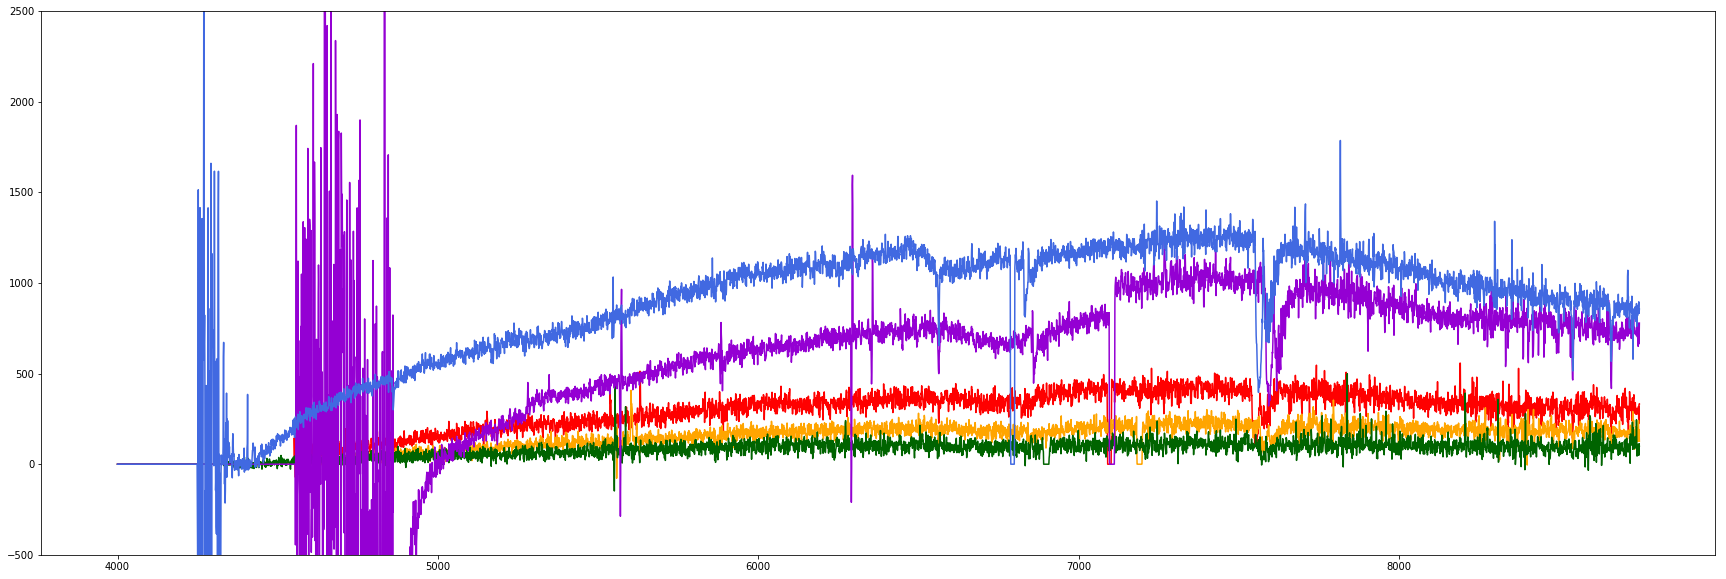

In [30]:
plt.figure(figsize = (30,10))
plt.plot(correct, newfluxDEGC, color = 'r')
plt.plot(correct, newfluxUDG, color = 'orange')
plt.plot(correct, newfluxH, color = 'darkgreen')
plt.plot(correct,newfluxICL, color = 'darkviolet')
plt.plot(correct,newfluxDENU, color = 'royalblue')
plt.ylim(-500,2500)

In [10]:
def normalize(minlim, maxlim, flux, ivar):
    correct = (np.arange(4000,8750.9,0.9)).tolist()      #correct from above being transferred for esay access for lists
    rangeflux = np.asarray(flux)[:, correct.index(min(correct, key=lambda x:abs(x-minlim))):
                                 correct.index(min(correct, key = lambda x:abs(x-maxlim)))] 
    #Hydrogen Alpha sort
    rowmedians=np.median(rangeflux, axis=1) #Have to look at medians in Angstrom height specifics
    
    for i in range(len(rangeflux)):
        flux[i] = flux[i]/rowmedians[i]
        ivar[i] = ivar[i] * np.power(rowmedians[i],2)
    return flux, ivar
    
nfluxDEGC, nvarDEGC = normalize(6500,6600, fluxesDEGC, varsDEGC)
nfluxUDG, nvarUDG = normalize(6500,6600, fluxesUDG, varsUDG)
nfluxH, nvarH = normalize(6500,6600, fluxesH, varsH)
nfluxDENU, nvarDENU = normalize(6500,6600, fluxesDENU, varsDENU) #something is up with this boi, but what...
nfluxICL, nvarICL = normalize(6500,6600, fluxesICL, varsICL)

(8400, 8450)

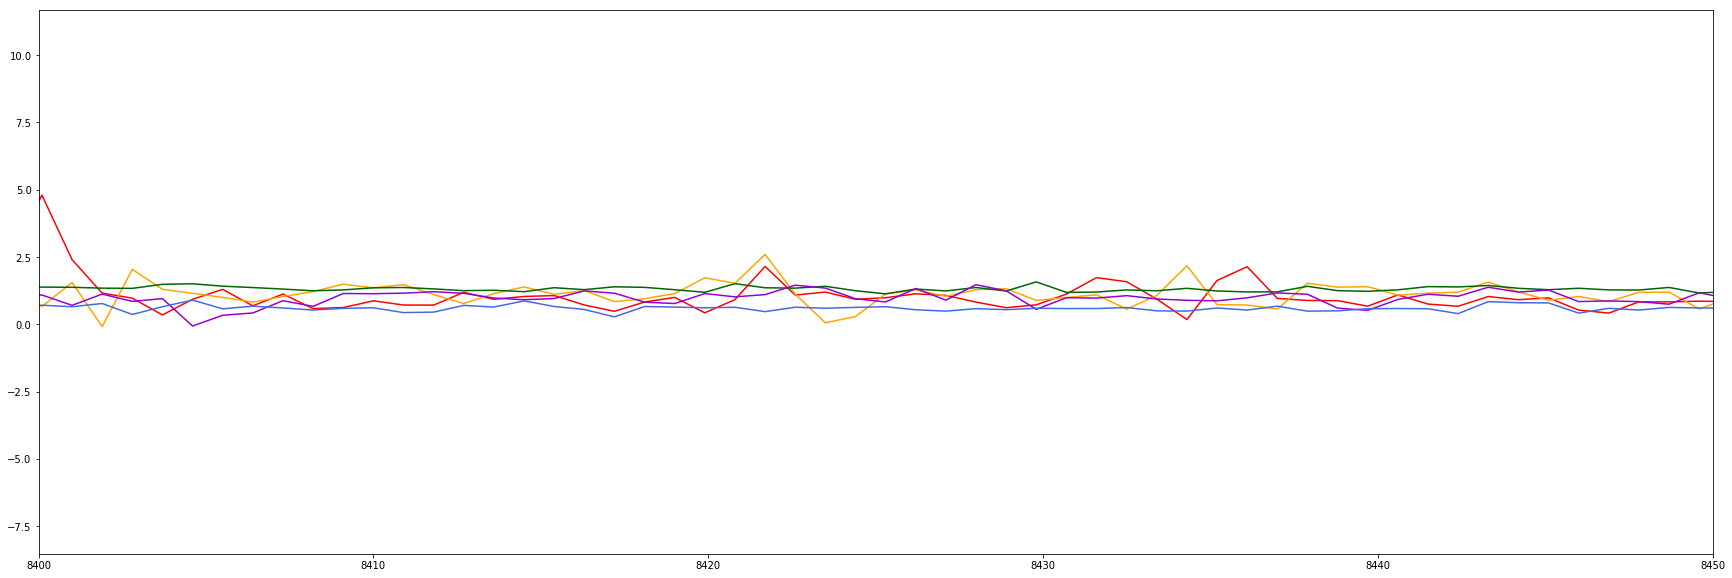

In [32]:
plt.figure(figsize = (30,10))
plt.plot(correct,nfluxDEGC[0], color = 'r')
plt.plot(correct,nfluxUDG[0], color = 'orange')
plt.plot(correct,nfluxH[0], color = 'darkgreen')
plt.plot(correct,nfluxICL[0], color = 'darkviolet')
plt.plot(correct,nfluxDENU[0], color='royalblue')
plt.xlim((8400,8450))

In [12]:
def sigmaclip(flux):                    #sigma clipping the flux
    ones = np.ones(np.shape(flux))
    stdev = np.std(flux, axis=0)
    median = np.median(flux,axis=0)
    a = ones[np.abs(flux-median) > 3 * stdev] = 0
    return(ones)
onesDEGC = sigmaclip(nfluxDEGC)
onesUDG = sigmaclip(nfluxUDG)
onesH = sigmaclip(nfluxH)
onesDENU = sigmaclip(nfluxDENU)
onesICL = sigmaclip(nfluxICL)

In [25]:
def coadd(flux, ivar, ones):
    coadd_spectra = np.nan_to_num(np.sum(flux * ivar * ones, axis = 0) / np.sum(ivar * ones, axis = 0))
    coadd_ivar = np.nan_to_num(np.sum(ivar * ones, axis = 0))
    coadd_err = np.nan_to_num(1 / np.sqrt(np.sum(ivar * ones, axis = 0)))
    return coadd_spectra, coadd_ivar, coadd_err

coadd_spectraUDG, coadd_ivarUDG, coadd_errUDG = coadd(nfluxUDG, nvarUDG, onesUDG)
coadd_spectraDEGC, coadd_ivarDEGC, coadd_errDEGC = coadd(nfluxDEGC, nvarDEGC, onesDEGC)
coadd_spectraH, coadd_ivarH, coadd_errH = coadd(nfluxH, nvarH, onesH)
coadd_spectraDENU, coadd_ivarDENU, coadd_errDENU = coadd(nfluxDENU, nvarDENU, onesDENU)
coadd_spectraICL, coadd_ivarICL, coadd_errICL = coadd(nfluxICL, nvarICL, onesICL)

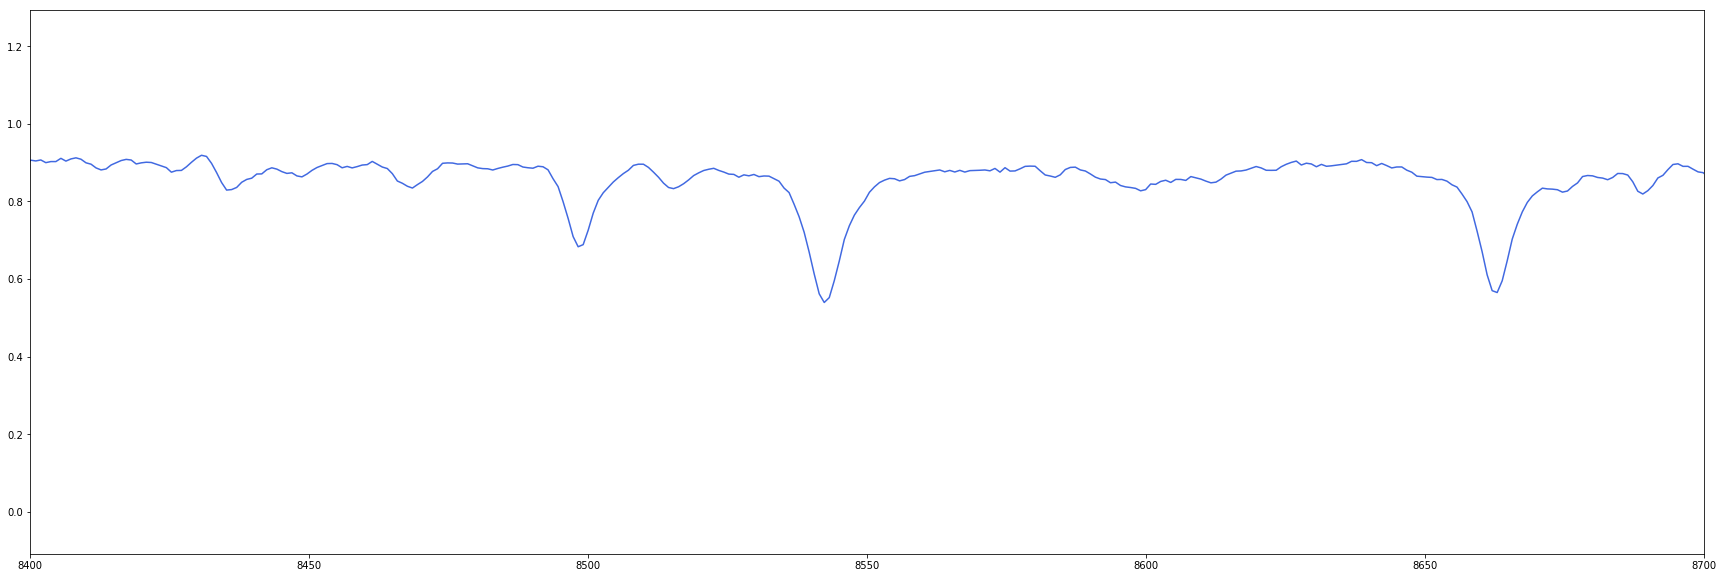

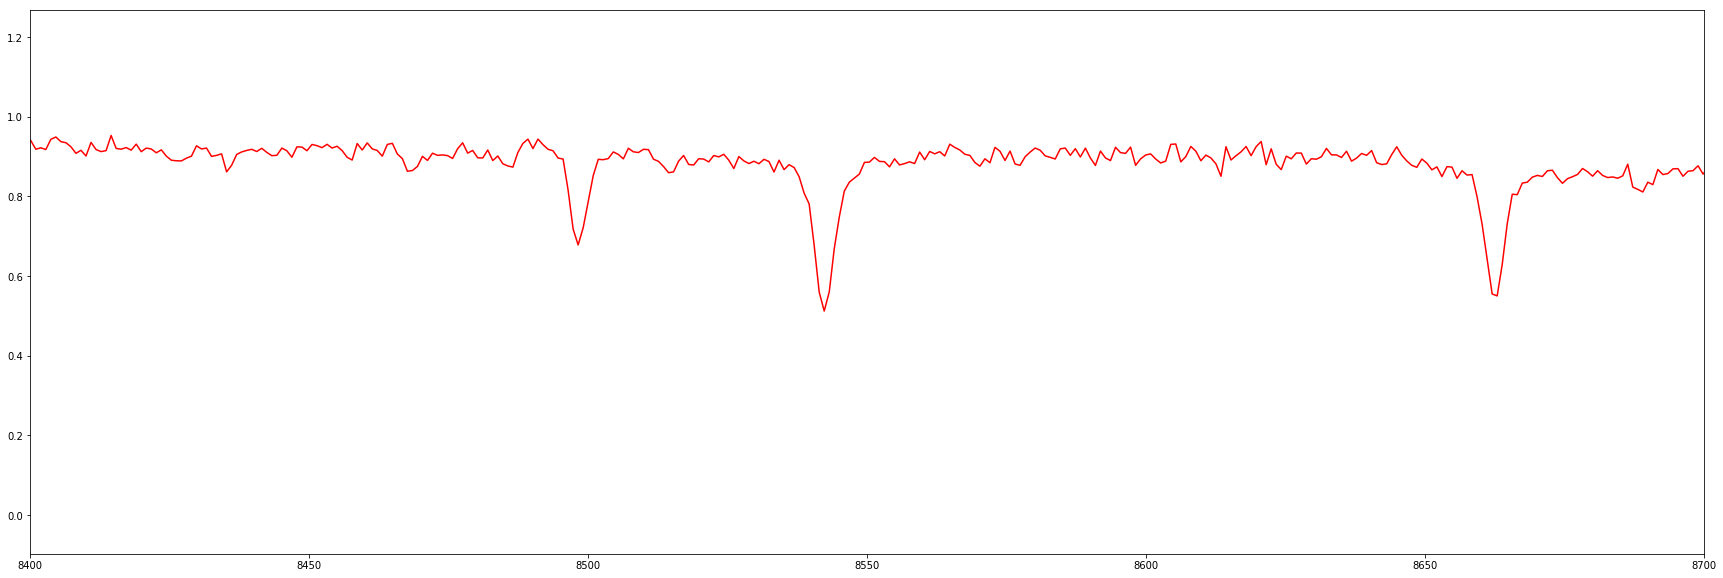

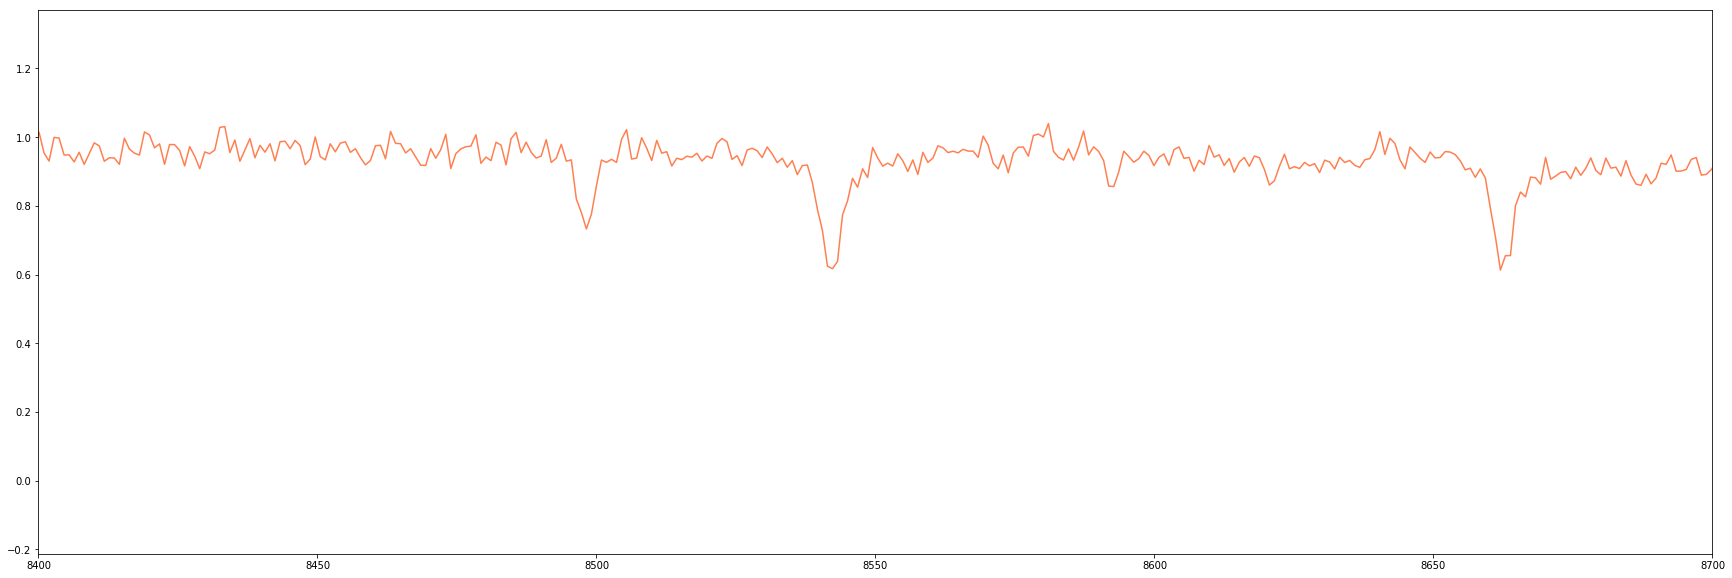

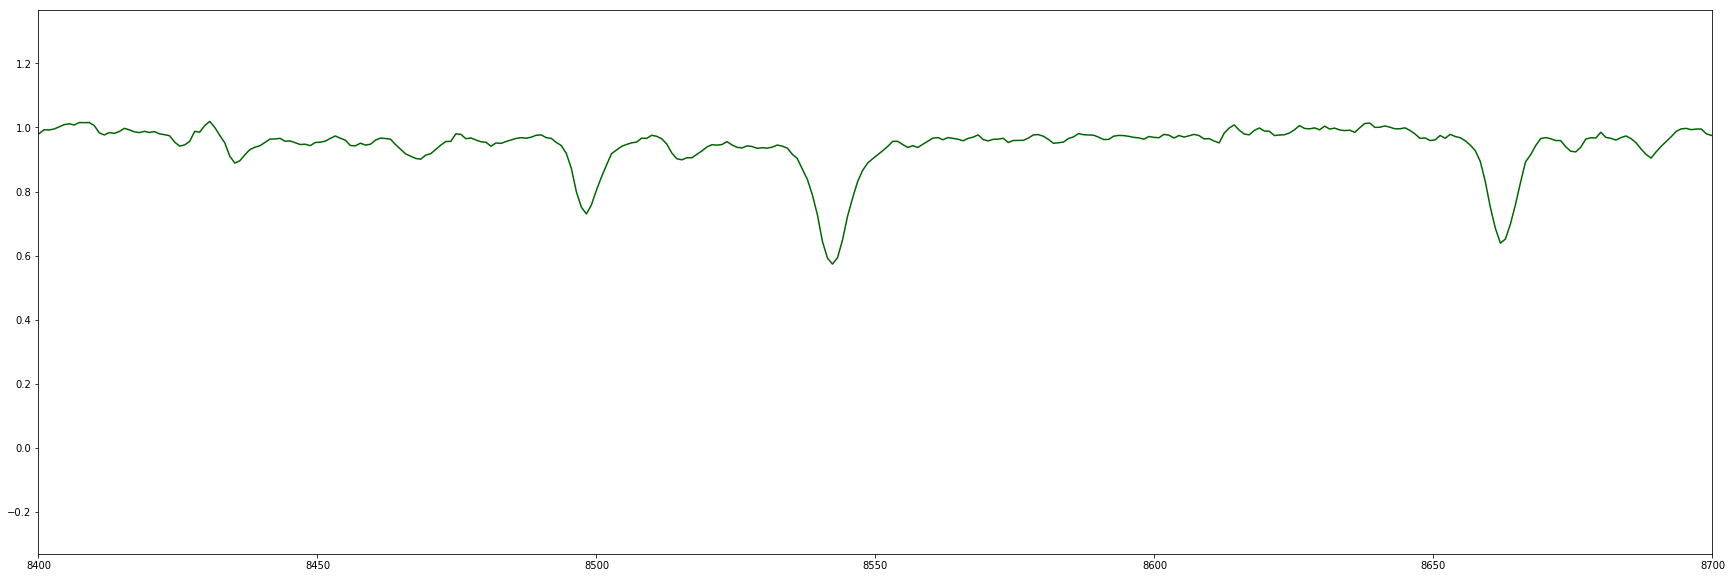

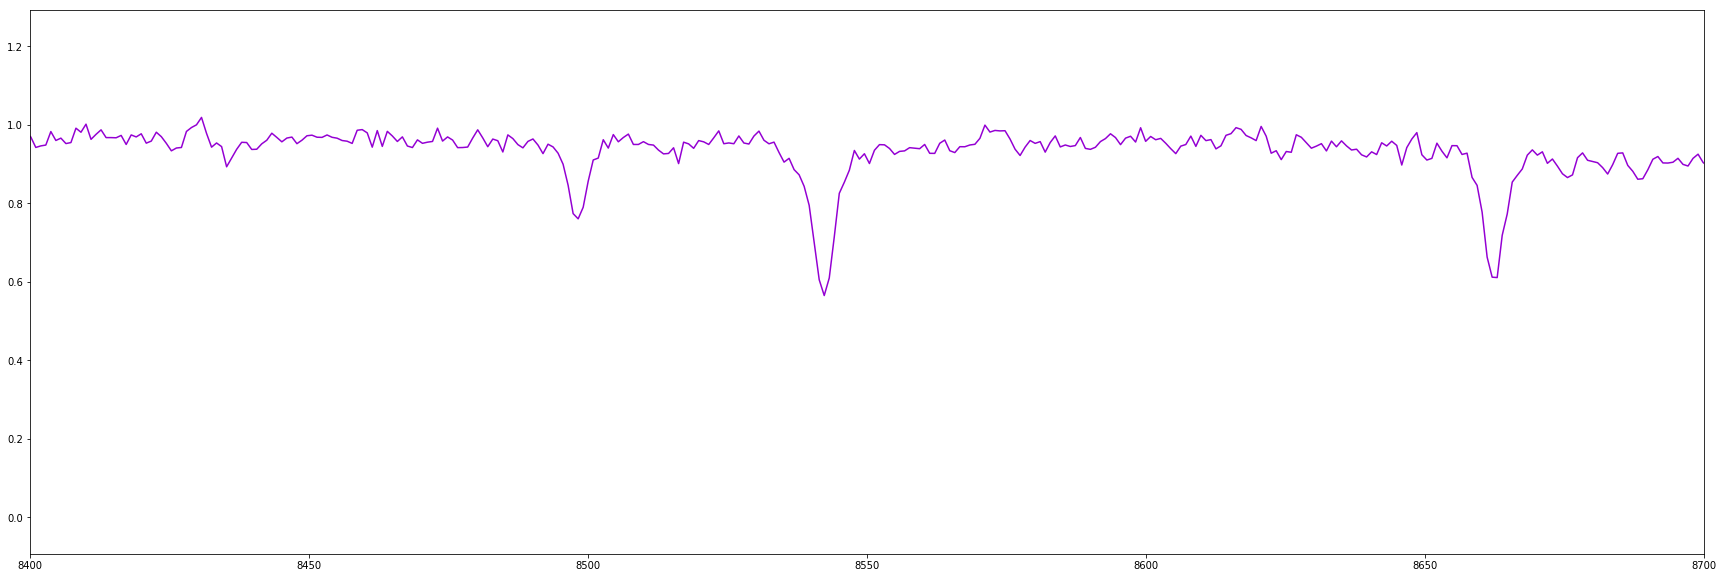

In [22]:
plt.figure(figsize = (30,10))
plt.plot(correct,coadd_spectraDENU, color = 'royalblue')
plt.xlim((8400,8700))
plt.show()
#When I graph this, the spectra line is in between 0.8 to 1. Everything else is almost 1. Honestly, so confused...

plt.figure(figsize = (30,10))
plt.plot(correct, coadd_spectraDEGC, color = 'r')
plt.xlim((8400,8700))
plt.show()

plt.figure(figsize = (30,10))
plt.plot(correct, coadd_spectraUDG, color = 'coral')
plt.xlim((8400,8700))
plt.show()

plt.figure(figsize = (30,10))
plt.plot(correct, coadd_spectraH, color = 'darkgreen')
plt.xlim((8400,8700))
plt.show()

plt.figure(figsize = (30,10))
plt.plot(correct, coadd_spectraICL, color = 'darkviolet')
plt.xlim((8400,8700))
plt.show()

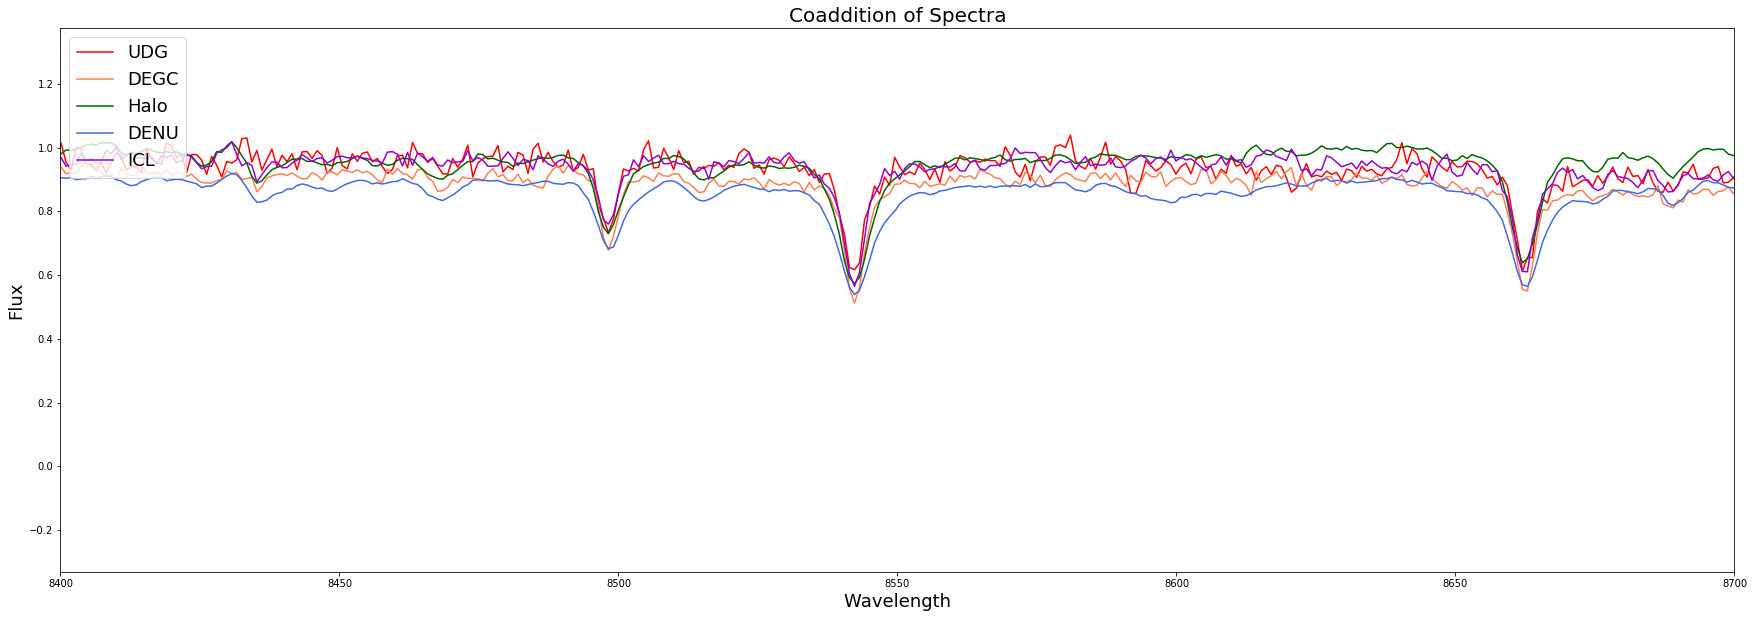

In [15]:
def plot(flux1, flux2, flux3, flux4, flux5, title, xlim):
    plt.figure(figsize = (30,10))
    plt.xlabel('Wavelength', fontsize=18)
    plt.ylabel('Flux', fontsize=18)
    plt.title(title, fontsize = 20)
    if (xlim):
        plt.xlim((8400,8700))
    plt.plot(correct, flux1, label = 'UDG', color = 'r')
    plt.plot(correct, flux2, label = 'DEGC', color = 'coral')
    plt.plot(correct, flux3, label = 'Halo', color = 'darkgreen')
    plt.plot(correct,flux4, label = 'DENU', color = 'royalblue')
    plt.plot(correct, flux5, label = 'ICL', color = 'darkviolet')
    plt.legend(loc = 'upper left', prop={'size':18})
    
plot(coadd_spectraUDG, coadd_spectraDEGC, coadd_spectraH, coadd_spectraDENU, coadd_spectraICL, 'Coaddition of Spectra', xlim = True)
